# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
from scipy import sparse
import string
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from wordcloud import WordCloud

from nltk.stem.porter import PorterStemmer
from datetime import datetime
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import tabulate

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

### The code for generating top features is in the code shown in Section 5.2 ###

### [5.2] Calulation of Co-occurrence matrix

In [0]:
# Please write all the code with proper documentation

In [ ]:
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np

import scipy


import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler

from bs4 import BeautifulSoup
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pickle

from tqdm import tqdm
import os
import time

class asign_11_dtcrea:

	def __init__(self):		
		self.X_train = pd.DataFrame()  
		self.feat_names = []
		self.top2000feat = []
		self.vocablry = {}
		self.max_features = None
		self.row = []
		self.col = []
		self.data = []
		self.tgt_word_count = 0

	#gridsearchcv parameters -- start
	@property
	def X_train(self):
	    return self._X_train

	@X_train.setter
	def X_train(self,new_X_train):
	    self._X_train = new_X_train        

        
	# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
	def partition(self,x):
		if x < 3:
			return 0
		return 1

	def write_ft_data(self,fnme,opdata):

		#fname = 'E:/appliedaicourse/assignments/dblite/kdtree_50k/' + fnme
		fname = 'E:/appliedaiacourse/assignments/dblite/asign-11-tsvd' + fnme
		with open(fname, 'wb') as fp:
			pickle.dump(opdata, fp)

	def write_data(self,fnme,opdata):    

		#fname = 'E:/appliedaicourse/assignments/dblite/kdtree_50k/' + fnme
		
		#fname = 'E:/appliedaiacourse/assignments/dblite/asign-11-tsvd' + fnme
		fname = 'D:/data/asign-11-tsvd'+ fnme
		print(fname)
		with open(fname, 'wb') as fp:
			pickle.dump(opdata, fp)
		

	def decontracted(self,phrase):
		# specific
		phrase = re.sub(r"won't", "will not", phrase)
		phrase = re.sub(r"can\'t", "can not", phrase)

		# general
		phrase = re.sub(r"n\'t", " not", phrase)
		phrase = re.sub(r"\'re", " are", phrase)
		phrase = re.sub(r"\'s", " is", phrase)
		phrase = re.sub(r"\'d", " would", phrase)
		phrase = re.sub(r"\'ll", " will", phrase)
		phrase = re.sub(r"\'t", " not", phrase)
		phrase = re.sub(r"\'ve", " have", phrase)
		phrase = re.sub(r"\'m", " am", phrase)

		return phrase			



	# Combining all the above statements 
	def rw_preproc(self,xdata):
		stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
		"you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
		'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
		'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
		'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
		'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
		'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
		'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
		'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
		'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
		's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
		've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
		"hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
		"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
		'won', "won't", 'wouldn', "wouldn't"])

		preprocessed_reviews = []

		# tqdm is for printing the status bar
		
		for sentance in tqdm(xdata.values):
			sentance = re.sub(r"http\S+", "", sentance)
			sentance = BeautifulSoup(sentance, 'lxml').get_text()
			sentance = self.decontracted(sentance)
			sentance = re.sub("\S*\d\S*", "", sentance).strip()
			sentance = re.sub('[^A-Za-z]+', ' ', sentance)
			# https://gist.github.com/sebleier/554280
			sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
			preprocessed_reviews.append(sentance.strip())
		return preprocessed_reviews


	def getreviews(self, nrows):
		X_trn = pd.DataFrame()		
		# using SQLite Table to read data.
		filepath = os.path.abspath('E:/appliedaiacourse/assignments/dblite/database.sqlite') 
		assert os.path.exists(filepath), 'the file does not exist'
		con = sqlite3.connect(filepath) 
		#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con)
		if nrows == -1 :
			# fetch all rows
			filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """ , con)			
		else:

			filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT """ + str(nrows), con)

		#changing reviews with score less than 3 to be positive and vice-versa
		actualScore = filtered_data['Score']
		positiveNegative = actualScore.map(self.partition) 
		filtered_data['Score'] = positiveNegative
		#Sorting data according to ProductId in ascending order
		sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')	
		#Deduplication of entries
		final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
		final.shape

		final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

		#Before starting the next phase of preprocessing lets see the number of entries left
		print(final.shape)

		#How many positive and negative reviews are present in our dataset?
		final['Score'].value_counts()

		self.X_train = self.rw_preproc(final['Text'])
		
	def TFIDFVectorizer(self):
		X_v_train = []
		tidfXtrain_scaled = []		

		#this is for gridsearchcv
		tf_idf_vect_1 = TfidfVectorizer(ngram_range=(1,1), min_df=4, max_features=4000) #in scikit-learn
		X_v_train = tf_idf_vect_1.fit_transform(self.X_train)								

		self.feat_names = tf_idf_vect_1.get_feature_names()
		self.write_ft_data('/tfidfvectorizer/tfidf_feat',tf_idf_vect_1.get_feature_names())
		print("some sample features(unique words in the corpus)",tf_idf_vect_1.get_feature_names()[0:10])
		print('='*50)
		
		idf_idx = np.argsort(tf_idf_vect_1.idf_)[::-1]

		top_n = 2000
		self.top2000feat = [self.feat_names[i] for i in idf_idx[:top_n]]

		idf_rev_list = []
		for i in idf_idx[:top_n]:
			idf_rev_list.append(tf_idf_vect_1.idf_[i])
		
		self.write_data('/tfidfvectorizer/idf_rev_lst.pkl',idf_rev_list)
		self.write_data('/tfidfvectorizer/idf_rev_ft.pkl',self.top2000feat)

	def create_feat_dict(self):
		for ftname in self.top2000feat:
			self.vocablry.setdefault(ftname,len(self.vocablry))
		#print(self.vocablry)


	def crea_sent_contxt_wrd(self,sentence):
		window=2
		focus_contxt = ()
		sent_contxt_wrds = []
		rvw = sentence.split()
		for i in range(0,len(rvw)):
			focus_wrd = rvw[i]
			low = max(0,i - window)
			high = min(len(rvw), i + window +1)
			#low = max(0,low)        
			#print('Context:',rvw[low:high])
			focus_contxt = (focus_wrd, rvw[low:high])
			sent_contxt_wrds.append(focus_contxt)
		return sent_contxt_wrds

	def crea_cocur_mtx(self):
		self.row =[]
		self.col = []
		self.data = []

		for j,review in enumerate(self.X_train):
			sent_contxt_wrd = self.crea_sent_contxt_wrd(review)
			print(sent_contxt_wrd)
			#print(review)
			rvw = review.split()
			for i,word in enumerate(rvw):
				print('next focus word', word)
				rw = self.vocablry.get(word,'Not Found') 
				if rw == 'Not Found':
					
					continue
				else:
					print('row found',word)
					context = sent_contxt_wrd[i][1]
					print(context)
					for wrd in context:
						if word == wrd:
							continue
						cl = self.vocablry.get(wrd,'Not Found')
						#print('word2', wrd,cl)
						if cl=='Not Found':
							#print('col not found',wrd)
							continue
						else:
							print('insertion',wrd,rw,cl)
							self.row.append(rw)
							self.col.append(cl)
							self.data.append(1.) 
			print('Processed  :',j,' review',review)	

		if len(self.row) > 0 and len(self.col) > 0:
			cocur_mtx = scipy.sparse.coo_matrix((self.data, (self.row, self.col)))
			print('-'*50)
			print('finished creating coo_matrix')
			self.write_data('/tfidfvectorizer/cocurmtx.pkl',cocur_mtx)
			self.write_data('/tfidfvectorizer/vocab.pkl',self.vocablry)			
		else:
			print('No coo_matrix',self.row,self.col) 




if __name__ == "__main__" :
	
	print('Process Starting')

	tsvd = asign_11_dtcrea()
	
	tsvd.getreviews(5000)	
	tsvd.max_features = 2000

	tsvd.TFIDFVectorizer()	
	tsvd.create_feat_dict()
	tsvd.crea_cocur_mtx() 

In [2]:
import pickle
fname = 'D:/data/asign-11-tsvd/tfidfvectorizer/cocurmtx.pkl'
with open(fname,'rb') as fp:
    cocur_mtx = pickle.load(fp)
#print(cocur_mtx.todense())

fname = 'D:/data/asign-11-tsvd/tfidfvectorizer/vocab.pkl'
with open(fname, 'rb') as fp:
    vocab = pickle.load(fp)
#print(vocab)
    
fname = 'D:/data/asign-11-tsvd/tfidfvectorizer/idf_rev_ft.pkl'
with open(fname, 'rb') as fp:
    tfidfeat = pickle.load(fp)

#### [5.2.1] Testing Co-occurance matrix ####

In [2]:
def crea_sent_contxt_wrd(sentence):
    window=2
    focus_contxt = ()
    sent_contxt_wrds = []
    rvw = sentence.split()
    for i in range(0,len(rvw)):
        focus_wrd = rvw[i]
        low = max(0,i - window)
        high = min(len(rvw), i + window +1)
        #low = max(0,low)        
        #print('Context:',rvw[low:high])
        focus_contxt = (focus_wrd, rvw[low:high])
        sent_contxt_wrds.append(focus_contxt)
    return sent_contxt_wrds

In [3]:
def crea_cocur_mtx():
    row =[]
    col = []
    data = []

    for review in reviews:
        sent_contxt_wrd = crea_sent_contxt_wrd(review)
        print(sent_contxt_wrd)
        print(review)
        rvw = review.split()
        for i,word in enumerate(rvw):
            print('next focus word', word)
            rw = top2000.get(word,'Not Found') 
            if rw == 'Not Found':
                continue
            else:
                context = sent_contxt_wrd[i][1]
                print(context)
                for wrd in context:
                    if word == wrd:
                        continue
                    cl = top2000.get(wrd,'Not Found')
                    if cl=='Not Found':
                        continue
                    else:
                        row.append(rw)
                        col.append(cl)
                        data.append(1.)
    print(row,col) 
    cocur_mtx = sparse.coo_matrix((data, (row, col)))
    print(cocur_mtx.todense())

In [4]:
top2000 = {'abc':0,'def':1,'pqr':2}
reviews = ["abc def ijk pqr",
          "pqr klm opq",
          "lmn pqr xyz abc def pqr abc"]

In [7]:
crea_cocur_mtx()

[('abc', ['abc', 'def', 'ijk']), ('def', ['abc', 'def', 'ijk', 'pqr']), ('ijk', ['abc', 'def', 'ijk', 'pqr']), ('pqr', ['def', 'ijk', 'pqr'])]
abc def ijk pqr
next focus word abc
['abc', 'def', 'ijk']
next focus word def
['abc', 'def', 'ijk', 'pqr']
next focus word ijk
next focus word pqr
['def', 'ijk', 'pqr']
[('pqr', ['pqr', 'klm', 'opq']), ('klm', ['pqr', 'klm', 'opq']), ('opq', ['pqr', 'klm', 'opq'])]
pqr klm opq
next focus word pqr
['pqr', 'klm', 'opq']
next focus word klm
next focus word opq
[('lmn', ['lmn', 'pqr', 'xyz']), ('pqr', ['lmn', 'pqr', 'xyz', 'abc']), ('xyz', ['lmn', 'pqr', 'xyz', 'abc', 'def']), ('abc', ['pqr', 'xyz', 'abc', 'def', 'pqr']), ('def', ['xyz', 'abc', 'def', 'pqr', 'abc']), ('pqr', ['abc', 'def', 'pqr', 'abc']), ('abc', ['def', 'pqr', 'abc'])]
lmn pqr xyz abc def pqr abc
next focus word lmn
next focus word pqr
['lmn', 'pqr', 'xyz', 'abc']
next focus word xyz
next focus word abc
['pqr', 'xyz', 'abc', 'def', 'pqr']
next focus word def
['xyz', 'abc', 'def', '

### [5.3] Finding optimal value for number of components (n) to be retained.

In [0]:
# Please write all the code with proper documentation

In [22]:
ncomp =[2,5,10,15,25,40,53,65,75,85,100,110,120,125,150,200,300,400,500,600,700,800,900,1000,1150,1300,1500,1600,\
       1700,1800,1900,1999]
start_tme = datetime.now()
expl_var_ratio = []
print("find expl var process starts",start_tme)
for i in ncomp:
    tsvd = TruncatedSVD(n_components=i,random_state=42)
    tsvd.fit(cocur_mtx.todense())    
    expl_var_ratio.append(np.sum(tsvd.explained_variance_ratio_))
    print('Finished processing component:#', i ,' Now: ', datetime.now(), ' Duration: ', datetime.now()-start_tme)

find expl var process starts 2019-09-27 12:19:42.256233
Finished processing component:# 2  Now:  2019-09-27 12:19:42.436243  Duration:  0:00:00.180010
Finished processing component:# 5  Now:  2019-09-27 12:19:44.649370  Duration:  0:00:02.393137
Finished processing component:# 10  Now:  2019-09-27 12:19:45.203401  Duration:  0:00:02.947168
Finished processing component:# 15  Now:  2019-09-27 12:19:47.278520  Duration:  0:00:05.022287
Finished processing component:# 25  Now:  2019-09-27 12:19:49.567651  Duration:  0:00:07.311418
Finished processing component:# 40  Now:  2019-09-27 12:19:51.947787  Duration:  0:00:09.691554
Finished processing component:# 53  Now:  2019-09-27 12:19:55.985018  Duration:  0:00:13.728785
Finished processing component:# 65  Now:  2019-09-27 12:19:58.380155  Duration:  0:00:16.123922
Finished processing component:# 75  Now:  2019-09-27 12:20:01.548336  Duration:  0:00:19.292103
Finished processing component:# 85  Now:  2019-09-27 12:20:03.982476  Duration:  0

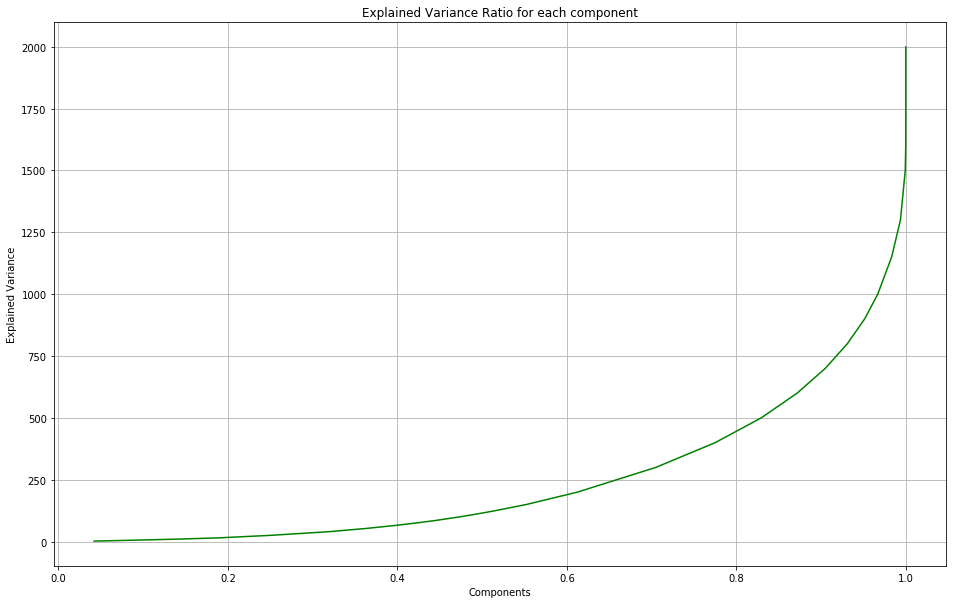

In [23]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(expl_var_ratio,ncomp,c='g')
#for i, txt in enumerate(np.round(expl_var_ratio,3)):
#    ax.annotate((ncomp[i],np.round(txt,3)), (ncomp[i],expl_var_ratio[i]))
plt.grid()
plt.title("Explained Variance Ratio for each component")
plt.xlabel("Components")
plt.ylabel("Explained Variance")
plt.show()

#### Using optimal number of components = <font color='red'>100 </font>####

In [3]:
tsvd = TruncatedSVD(n_components=100,random_state=42)
tsvd.fit(cocur_mtx.todense())    
print(tsvd.explained_variance_ratio_)


[0.02123773 0.02086919 0.01358581 0.01283822 0.01283544 0.01285449
 0.01274992 0.01190114 0.01144402 0.01128598 0.01072778 0.01048864
 0.0090681  0.00868028 0.00822102 0.00691167 0.00687163 0.00677654
 0.0060346  0.00599213 0.00587185 0.00580697 0.00547829 0.00548577
 0.00533295 0.0052521  0.00526914 0.0051846  0.0051383  0.00504399
 0.00503552 0.00485772 0.00475201 0.00448371 0.00439867 0.00441069
 0.00436148 0.00424011 0.00400542 0.00393701 0.00369986 0.00359941
 0.00366661 0.00364522 0.00361424 0.00338413 0.00334182 0.00326977
 0.00328351 0.00317204 0.00310739 0.00312874 0.00311357 0.00308139
 0.00305516 0.00297469 0.00297292 0.00282504 0.00278603 0.00278392
 0.00278049 0.00270919 0.00272544 0.00272126 0.00268547 0.00266481
 0.00265433 0.00259652 0.00257113 0.00257522 0.00255505 0.00243987
 0.00245269 0.00242691 0.00241903 0.0023853  0.00238257 0.00228043
 0.00223868 0.00220762 0.00214516 0.00215516 0.00215167 0.00213827
 0.00210367 0.0020558  0.00201867 0.00201059 0.00201477 0.0019

#### Transforming the original matrix from higher to lower dimension ####

In [4]:
new_mtx=tsvd.transform(cocur_mtx.todense())

### [5.4] Applying k-means clustering

In [0]:
# Please write all the code with proper documentation

In [165]:
kmeans = KMeans(n_clusters=10,n_jobs=3, random_state=42, verbose=200)
kmeans.fit(new_mtx)
labels = kmeans.labels_

tfidflblftnme = sorted(zip(labels,tfidfeat))

tfidfwrdcld = [word for word in tfidflblftnme]
df = pd.DataFrame(tfidfwrdcld, columns =['lbl', 'ftname'])

In [47]:
 optk = list(np.unique(labels))

### [5.5] Wordclouds of clusters obtained in the above section

In [0]:
# Please write all the code with proper documentation

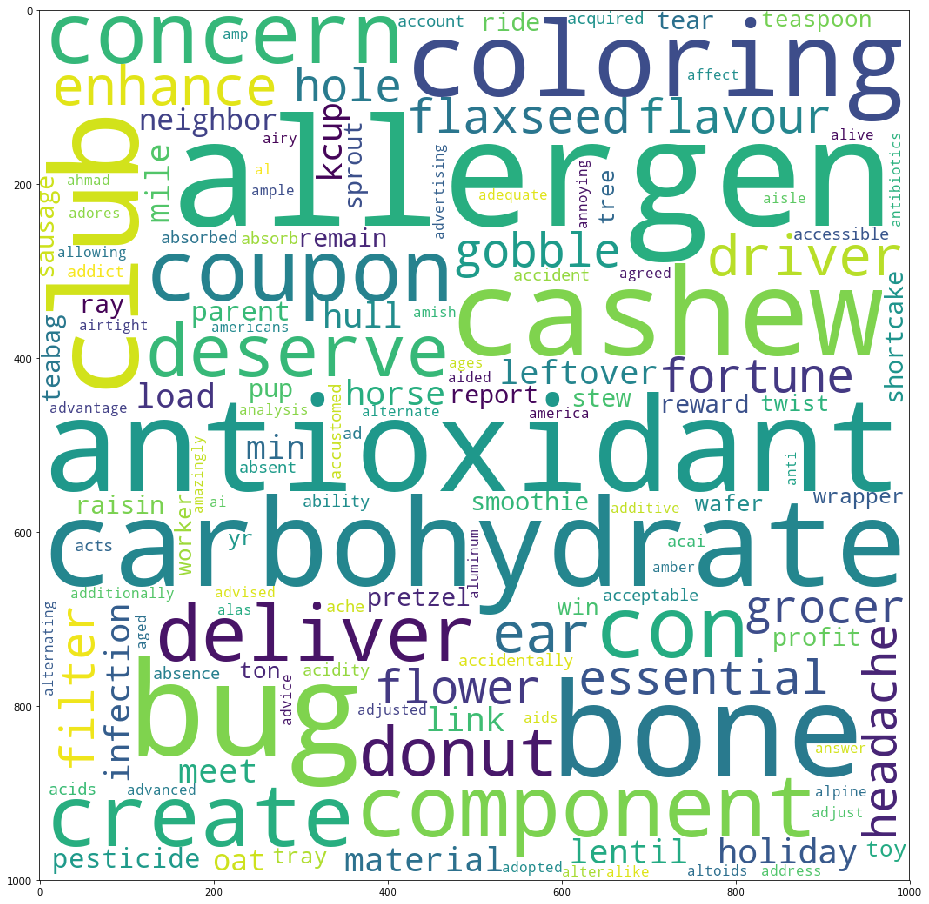

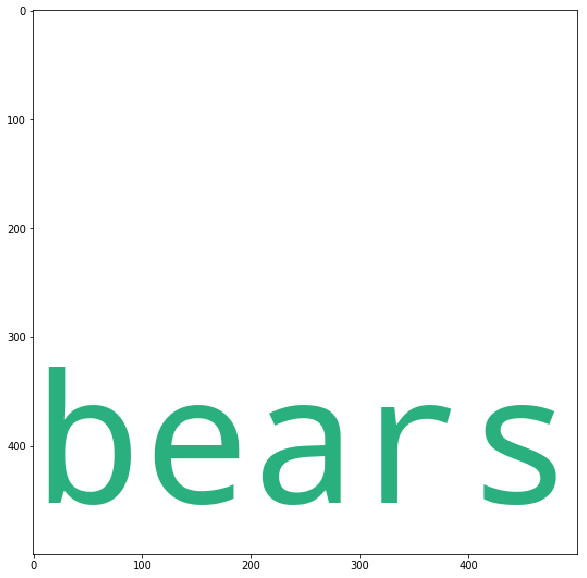

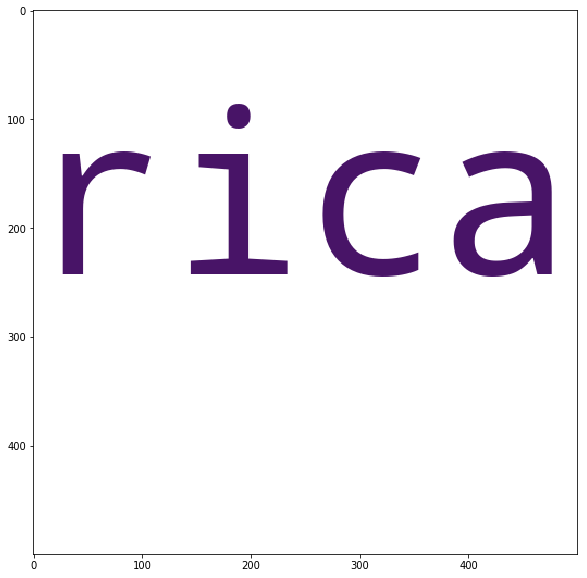

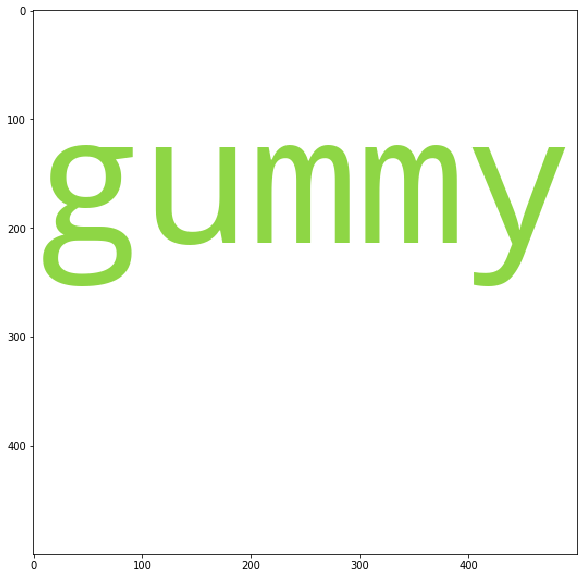

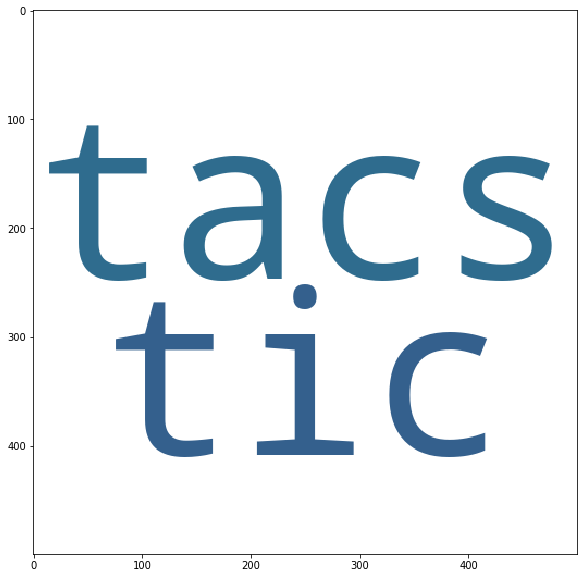

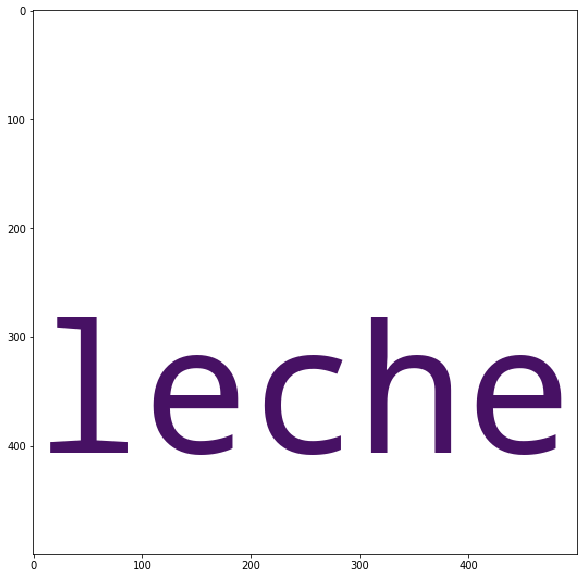

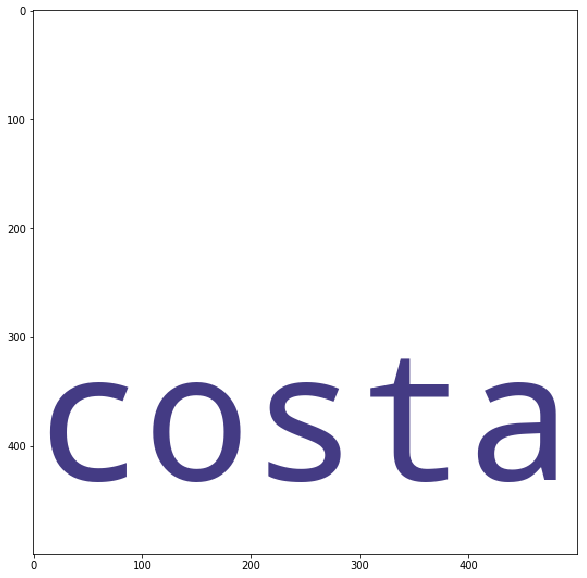

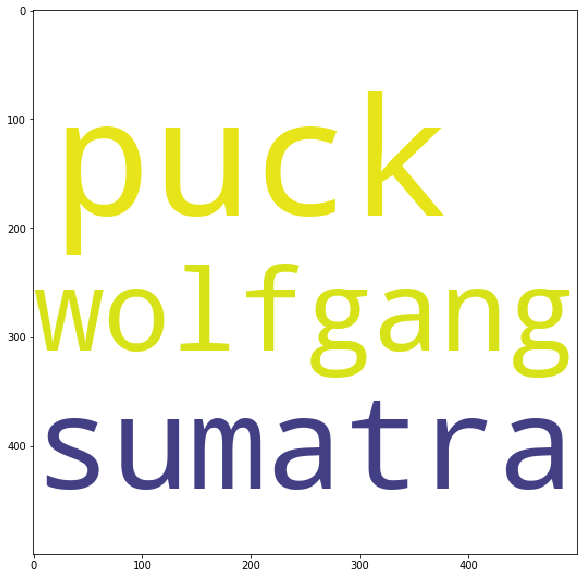

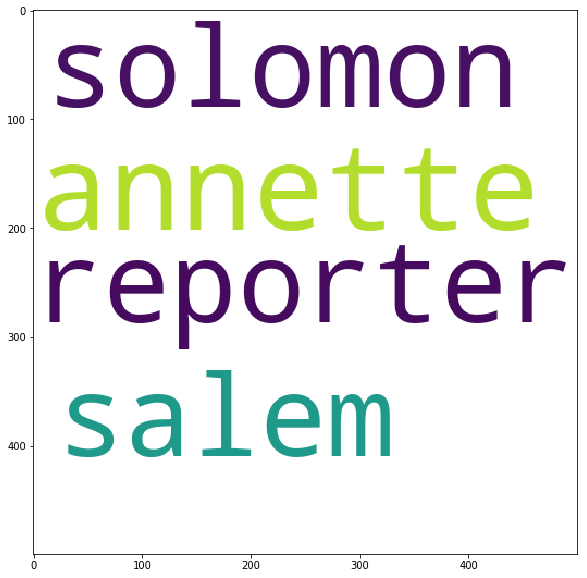

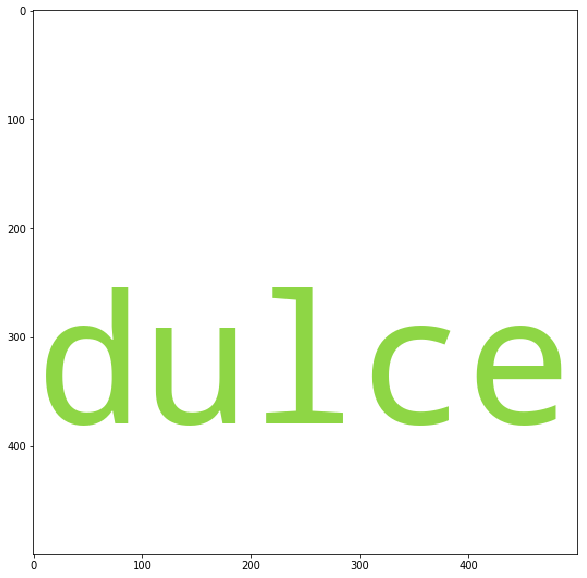

In [49]:
for i in optk:
    a= list(df[df.lbl == i]['ftname'])    
    str1 = ' '.join(str(e) for e in a)  
    if i == 0 :
        wordcld = WordCloud(width=1000, height=1000, background_color = 'white',min_font_size=14).generate(str1)
        plt.figure(figsize=(16,16))
    else:
        wordcld = WordCloud(width=500, height=500, background_color = 'white',min_font_size=8).generate(str1)
        plt.figure(figsize=(10,10))
    plt.imshow(wordcld) 

### [5.6] Function that returns most similar words for a given word.

In [0]:
# Please write all the code with proper documentation

In [6]:
print(new_mtx.shape)

(2000, 100)


In [42]:
#from sklearn.metrics.pairwise import cosine_similarity
def get_similar_words(given_word):
    cos_simil = []
    cos_simil_lib = []
    #given_word = 'crispbread'
    i = tfidfeat.index(given_word)
    #print(i)
    if i :
        for j in range(0,1999):        
            dot_prod = np.dot(new_mtx[i],new_mtx[j])
            norm1 = np.linalg.norm(new_mtx[i])
            norm2 = np.linalg.norm(new_mtx[j])
            cos1 = dot_prod / (norm1 * norm2)
            if i != j: 
                cos_simil.append(cos1)
                #cos2 = cosine_similarity(new_mtx[i].reshape(1,-1),new_mtx[j].reshape(1,-1))
                #cos_simil_lib.append(cos2)
                #print(cos1, cos2)
        top_cosimil_fn = []
        top_cosimil_ft = []
        
        for i in cosimil_idx :
            if not(np.isnan(cos_simil[i])) and i !=0 :        
                top_cosimil_fn.append(cos_simil[i]) 
                top_cosimil_ft.append(tfidfeat[i]) 
        if len(top_cosimil_fn) > 0 :
            for j in range(0,19):
                print(top_cosimil_fn[j],top_cosimil_ft[j])
        else:
            print("Not able to find similar words for the selected word:",given_word,".")
    else:
        print(given_word,'Is not part of Top 2000. Only words present in Top 2000 features can be used')
       

In [34]:
get_similar_words('crispbread')

0.9906464335557039 unsalted
0.9872056464738044 costly
0.9751241107573054 senses
0.9521259959121324 lobster
0.8366478760718714 disgusted
0.8184592135732645 reply
0.8149613106155542 grateful
0.81036352909496 recieved
0.7391010403985433 reminiscent
0.6295840089829084 updated
0.616240286128393 digestion
0.567608787849009 holiday
0.510126116693823 lactose
0.498219863032091 component
0.48331647709971576 settled
0.47052174232886296 regardless
0.4626171277787581 unnecessary
0.43851004067944516 farm
0.40226568271596463 grandchildren


In [43]:
get_similar_words('magnesium')

Not able to find similar words for the selected word: magnesium .


# [6] Conclusions

In [ ]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.

#### Being an unsupervised learning oriented assignment not able to judge the quality of the results produced. ####
#### Depends heavily on the quality of the Vectorizer and the feature items produced by the vectorizer. ####
#### In this assignment I don't know how to improve the performance of the model . ####

### Number of components ###

#### We had to use the elbow method to get the number of components . ####
#### Unfortunately the graph that I could generate had no clear elbow and graph was smoothly increasing. ####
#### Due to the absence of a clear elbow I have taken  <font color='red'> 100</font> as the number of components ####
#### which can again be non-optimal and hence produce results of less quality. ####

### Number of Clusters ###

#### I tried processing the clustering with different values but the algorithm was generating one big cluster with label 0 ####
#### with a lot of data points and realtively smaller clusters with fewer data points . ####
#### I have used <font color='red'> 10</font> as the value for n_clusters . ####

### Find similar Words using Co-sine similarity ###

In [5]:
head_tab = [['Query Word','crispbread']]
print(tabulate.tabulate(head_tab,tablefmt='fancy_grid'))

res_tab =[["Cosine \nSimilarity","Feature \nname"],
[ 0.9906464335557039,"unsalted"],
[ 0.9872056464738044 ,"costly"],
[0.9751241107573054 ,"senses"],
[0.9521259959121324 ,"lobster"],
[0.8366478760718714 ,"disgusted"],
[0.8184592135732645 ,"reply"],
[0.8149613106155542 ,"grateful"],
[0.81036352909496 ,"recieved"],
[0.7391010403985433 ,"reminiscent"],
[0.6295840089829084 ,"updated"],
[0.616240286128393 ,"digestion"],
[0.567608787849009 ,"holiday"],
[0.510126116693823 ,"lactose"],
[0.498219863032091 ,"component"],
[0.48331647709971576 ,"settled"],
[0.47052174232886296 ,"regardless"],
[0.4626171277787581 ,"unnecessary"],
[0.43851004067944516 ,"farm"],
[0.40226568271596463 ,"grandchildren"]]
    
print(tabulate.tabulate(res_tab,tablefmt='fancy_grid'))

╒════════════╤════════════╕
│ Query Word │ crispbread │
╘════════════╧════════════╛
╒═════════════════════╤═══════════════╕
│ Cosine              │ Feature       │
│ Similarity          │ name          │
├─────────────────────┼───────────────┤
│ 0.9906464335557039  │ unsalted      │
├─────────────────────┼───────────────┤
│ 0.9872056464738044  │ costly        │
├─────────────────────┼───────────────┤
│ 0.9751241107573054  │ senses        │
├─────────────────────┼───────────────┤
│ 0.9521259959121324  │ lobster       │
├─────────────────────┼───────────────┤
│ 0.8366478760718714  │ disgusted     │
├─────────────────────┼───────────────┤
│ 0.8184592135732645  │ reply         │
├─────────────────────┼───────────────┤
│ 0.8149613106155542  │ grateful      │
├─────────────────────┼───────────────┤
│ 0.81036352909496    │ recieved      │
├─────────────────────┼───────────────┤
│ 0.7391010403985433  │ reminiscent   │
├─────────────────────┼───────────────┤
│ 0.6295840089829084  │ updated     